In [15]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

# Note that Keras should only be imported after the backend
# has been configured. The backend cannot be changed once the
# package is imported.
import keras
import pydub
import matplotlib.pyplot as plt

In [90]:
from keras import Sequential
from keras.layers import Dense

In [16]:
def read(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

def write(f, sr, x, normalized=False):
    """numpy array to MP3"""
    channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")


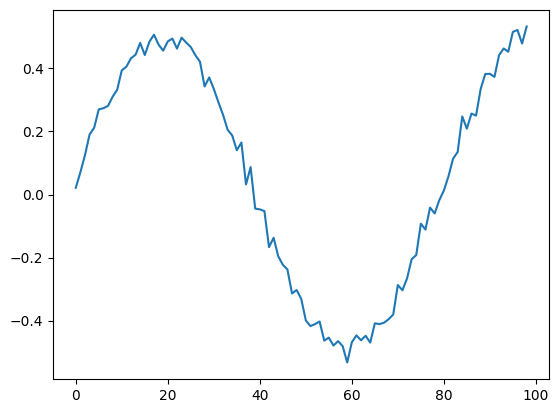

In [94]:
# Generate sine wave
def gen_sine(freq, sr, secs, noise_sd=False):
    num = int(sr*secs)
    testing_np_version = np.zeros((num, 2))
    testing_np_version[:, 0] = np.sin(2 * np.pi * np.arange(num) * freq / sr) * 0.5
    testing_np_version[:, 1] = np.sin(2 * np.pi * np.arange(num) * freq / sr) * 0.5
    
    if noise_sd is not None:
        # Add noise
        testing_np_version[:, 0] += np.random.normal(0, noise_sd, size=num)
        testing_np_version[:, 1] += np.random.normal(0, noise_sd, size=num)

    return testing_np_version

secs = 1/96
sr = 48000
freq = 600
testing_np_version = gen_sine(freq, sr, secs, noise_sd=0.03)
plt.plot(testing_np_version[1:100, 0])
plt.show()

In [95]:
write("mp3_check.mp3",sr,testing_np_version,normalized=True)

In [121]:
# Randomly generate frequencies between C2 and C8
c2 = 65.41
c8 = 4186.01
c7 = 2093.00

# Generate N training samples
N = 10000
freqs = np.random.uniform(c2, c8, size=N)
noise_sds = np.random.exponential(0.02, size=N)
X_lst = []
for i in range(N):
    sine = gen_sine(freqs[i], sr=48000, secs=1/96, noise_sd=noise_sds[i])[:, 0]
    X_lst.append(sine)

X = np.stack(X_lst)
y = freqs
split = 0.7
X_train = X[:int(split*len(X_lst))]
y_train = freqs[:int(split*len(X_lst))]
X_test = X[int(split*len(X_lst)):]
y_test = freqs[int(split*len(X_lst)):]
X_train.shape

(7000, 500)

In [102]:
# Build network
input_shape = len(X_lst[0])
 # create model
model = keras.Sequential()
model.add(Dense(input_shape, input_shape=(input_shape,), kernel_initializer='normal', activation='relu'))
model.add(Dense(input_shape, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
 
# Display a summary of the model architecture.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 500)               250500    
                                                                 
 dense_10 (Dense)            (None, 500)               250500    
                                                                 
 dense_11 (Dense)            (None, 1)                 501       
                                                                 
Total params: 501,501
Trainable params: 501,501
Non-trainable params: 0
_________________________________________________________________


In [125]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(X, y, validation_split=0.2, batch_size=int(N*0.1), epochs=30, callbacks=[callback])

Epoch 1/30


8/8 [==============================] - 0s 27ms/step - loss: 1823.1412 - val_loss: 1571.4365
Epoch 2/30
8/8 [==============================] - 0s 20ms/step - loss: 801.7208 - val_loss: 1136.9128
Epoch 3/30
8/8 [==============================] - 0s 20ms/step - loss: 607.3923 - val_loss: 819.2043
Epoch 4/30
8/8 [==============================] - 0s 20ms/step - loss: 400.4220 - val_loss: 772.5770
Epoch 5/30
8/8 [==============================] - 0s 21ms/step - loss: 339.4981 - val_loss: 707.7486
Epoch 6/30
8/8 [==============================] - 0s 21ms/step - loss: 305.1677 - val_loss: 682.3585
Epoch 7/30
8/8 [==============================] - 0s 20ms/step - loss: 287.1718 - val_loss: 668.1041
Epoch 8/30
8/8 [==============================] - 0s 18ms/step - loss: 280.3440 - val_loss: 664.1005
Epoch 9/30
8/8 [==============================] - 0s 20ms/step - loss: 274.1039 - val_loss: 658.8346
Epoch 10/30
8/8 [==============================] - 0s 19ms/step - loss: 271.2186 - val_loss: 653.95

In [126]:
model.predict(X_test[:2])

1/1 [==============================] - 0s 13ms/step


array([[3894.9263],
       [4103.994 ]], dtype=float32)

In [127]:
y_test[:2]

array([3874.39827907, 4085.66597677])